# mix-up을 통한 test데이터 정확도 상승

resnet-101 학습에서 mixup을 통한 학습률 증가

-코드 설명편

----------------------------------------------------------
## 1. 마스크 검사
아래는 마스크를 쓴 사진과 안쓴 사진을 데이터 셋으로 가지는 모델의 학습니다.

원본 코드 & 데이터셋 : 
https://github.com/prajnasb/observations/blob/master/mask_classifier/training.ipynb


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import time
import copy

먼저 필요로하는 라이브러리 임포트

In [ ]:
!git clone https://github.com/prajnasb/observations

Cloning into 'observations'...
remote: Enumerating objects: 1638, done.
remote: Total 1638 (delta 0), reused 0 (delta 0), pack-reused 1638
Receiving objects: 100% (1638/1638), 75.94 MiB | 26.62 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [ ]:
!ls observations/experiements/dest_folder/

test  test.csv	train  train.csv  val


위에서 데이터셋을 가져온다.

### Creating image datasets an data loaders for train and test using the experiments folder split

dir를 적고 transform을 정한다.  
resnet 101의 입력은 224 * 224 형태여야 한다.  
데이터셋 세팅 설명은 생략한다.

In [ ]:
experiments_path = 'observations/experiements/dest_folder/'
data_path = 'observations/experiements/data/'

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'test' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
def get_train_files_path(experiments_path, data_path, phase):
    if phase == 'train':
        file_name = 'train.csv'
    elif phase == 'test':
        file_name = 'test.csv'
    else:
        print("phase can only have train and test as parameter values")
        exit()
    file_path = os.path.join(experiments_path, file_name)
    train_df = pd.read_csv(file_path, delimiter=',')
    files_path = []
    fonts_class = []
    for row in train_df.iterrows():
        files_path.append(os.path.join(data_path, row[1]['class'], row[1]['filename']))
        fonts_class.append(row[1]['class'])
    
    return files_path, fonts_class

In [ ]:
def copy_images_to_path(file_path, file_class, destination_dir):
    font_folder = os.path.join(destination_dir, file_class)
    if os.path.exists(font_folder) == False:
        os.makedirs(font_folder)
    
    print("File being copied from {}:{}".format(file_path, font_folder))
    shutil.copy(file_path, font_folder)
    #shutil.copyfile(file_path, font_folder)
    

In [ ]:
X_train, y_train = get_train_files_path(experiments_path, data_path, phase='train')
X_test, y_test = get_train_files_path(experiments_path, data_path, phase='test')

In [ ]:
train_dir = os.path.join(experiments_path, 'train')
test_dir = os.path.join(experiments_path, 'test')

if not os.path.exists(train_dir):
    os.makedirs(train_dir)

if not os.path.exists(test_dir):
    os.makedirs(test_dir)

In [ ]:
for file_path, font_class in zip(X_train, y_train):
    copy_images_to_path(file_path, font_class, train_dir)

File being copied from observations/experiements/data/with_mask/0-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/10-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/100-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/101-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/103-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/104-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/data/with_mask/105-with-mask.jpg:observations/experiements/dest_folder/train/with_mask
File being copied from observations/experiements/da

In [ ]:
for file_path, font_class in zip(X_test, y_test):
    copy_images_to_path(file_path, font_class, test_dir)

File being copied from observations/experiements/data/with_mask/1-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/106-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/11-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/110-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/111-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/114-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with_mask/121-with-mask.jpg:observations/experiements/dest_folder/test/with_mask
File being copied from observations/experiements/data/with

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(experiments_path, x), data_transforms[x]) for x in ['train', 'test']}

In [ ]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 1315
    Root location: observations/experiements/dest_folder/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
image_datasets['test']

Dataset ImageFolder
    Number of datapoints: 194
    Root location: observations/experiements/dest_folder/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                             batch_size=16, 
                                             shuffle=True, 
                                             num_workers=4) 
               for x in ['train', 'test']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
dataloaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7fafd3b8ae10>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7fb041cc2f90>}

In [ ]:
class_names = image_datasets['train'].classes

In [ ]:
class_names

['with_mask', 'without_mask']

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}


### Visualizing images

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20,20))
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    

In [ ]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


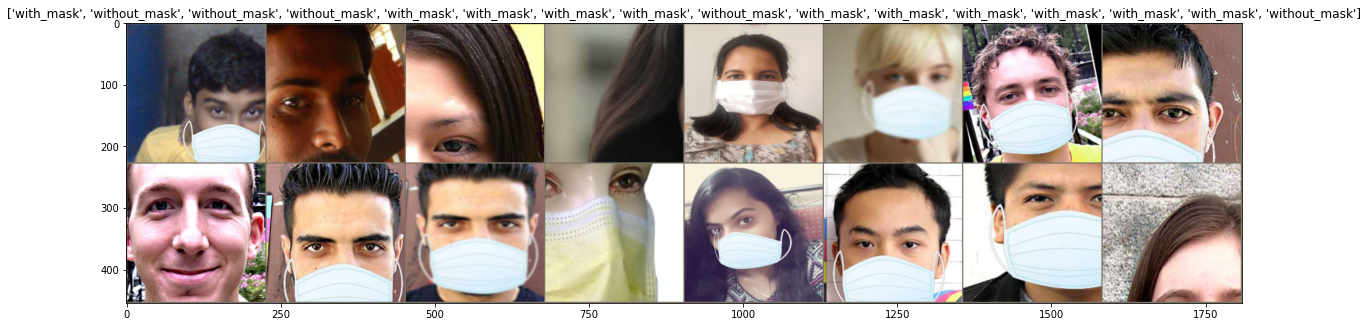

In [ ]:
imshow(out, title=[class_names[x] for x in classes])

# Mixup 함수
*mixup_data*  
x는 인풋, y는 라벨이다.  
섞는 비율인 lam을 정한다.  
mini_batch 크기로 리스트가 들어오면 랜덤하게 두 x인 a,b의 값을 섞고,  
어떤 라벨끼리 섞였는지 기억한 다음,  
mixed_x, y_a, y_b, lam을 반환한다.

*mixup_criterion*  
criterion을 할때 섞여있는 mixed_x의 output이  y_a, y_b을 얼마나 맞췄는지 cross_entropy를 통해 각각 구하고 lam 비율로 합쳐 반환한다.


In [ ]:
mixup_alpha = 1.0

def mixup_data(x, y):
    lam = np.random.beta(mixup_alpha, mixup_alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

### Training the model
프레임워크로 대부분의 과정은 함축되어 있다.   
mixup을 위해서 'train'때 mixup 과정을 추가한다.  

inputs과 labels를 mixup_data(inputs,labels)에 넣고,  
inputs를 모델에 넣어 output을 구한다음,  
mixup_criterion() 함수를 통해 loss를 구한다.  

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20,mixup=False):
    train_acc_list=[]
    test_acc_list=[]
    train_loss_list=[]
    test_loss_list=[]
    since = time.time()
    best_acc = 0.0
    best_model = copy.deepcopy(model.state_dict())
    
    new_freeze_state = None
    prev_freeze_state = False
    print("mixup : ",mixup )


    for epoch in range(num_epochs):                               # 에폭 반복
        print("Epoch {}/{}".format(epoch, num_epochs - 1))     
        print('-' * 10)

        for phase in ['train', 'test']:                           # Train이냐 Test이냐
            if phase == 'train':
                scheduler.step()                                  # 학습률을 관리하는 스케쥴
                model.train()                                     # 학습
            else:
                model.eval()                                      # 평가
                
            running_loss = 0.0       # 손실
            running_corrects = 0     # 정확도

            train_loss = 0   # mixup
            correct = 0
            total = 0        #
        
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)                # 입력과 라벨을 꺼낸다
                if phase == 'train' and mixup==True:
                    inputs, targets_a, targets_b, lam = mixup_data(inputs, labels) # mixup

                optimizer.zero_grad()                     # 기울기값을 초기화해주지 않으면 남아있는 경우가 있어 필수이다.
                
                
                with torch.set_grad_enabled(phase == 'train'):  # 기울기를 설정할 수 있는 층이면
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)            

                    if phase == 'train' and mixup==True:
                        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam) #mixup
                    else :
                        loss = criterion(outputs, labels)     #cross_entropy

                    if phase == 'train':                      #train 일때만 역전파
                      loss.backward()
                      optimizer.step()                        # params 수정
                    
                    running_loss += loss.item() * inputs.size(0)
                    if phase == 'train' and mixup==True:
                      running_corrects +=(lam * preds.eq(targets_a).sum().item() + (1 - lam) * preds.eq(targets_b).sum().item())  #mixup
                    else:
                      running_corrects += preds.eq(labels).sum().item()     # 미니배치중 맞힌 겟수

            epoch_loss = running_loss / dataset_sizes[phase]      # 맞힌 확률
            epoch_acc = running_corrects / dataset_sizes[phase]
            if phase == 'train':
              train_acc_list.append(epoch_acc)
              train_loss_list.append(epoch_loss)
            else:
              test_acc_list.append(epoch_acc)
              test_loss_list.append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc:{:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
            
            print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model)
    return model,train_acc_list,test_acc_list,train_loss_list,test_loss_list
                

In [ ]:
import ssl


In [ ]:
ssl._create_default_https_context = ssl._create_unverified_context  # 보안

In [ ]:
model_ft = models.resnet101(pretrained=True)      #선행학습을 시킨 resnet101 모델

num_frts = model_ft.fc.in_features  # 각 입력 샘플의 크기
model_ft.fc = nn.Linear(num_frts, len(class_names)) # 입력과 출력 크기 지정

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()  # 손실함수

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.001)   # optimizer 정의
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)  # pytorch에서 제공해주는 lr_scheduler 정의

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


아래는 그래프를 그려주는 함수이다.

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

def draw_plt(train_acc,test_acc,train_loss,test_loss):
    # Get number of epochs
    epochs = range(len(test_acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, test_acc)
    plt.plot(epochs, train_acc)
    plt.title('Training and validation accuracy')

    plt.figure()

    # Plot training and validation loss per epoch
    plt.plot(epochs, train_loss)
    plt.plot(epochs, test_loss)
    plt.title('Training and validation loss')

각각의 pretrain과 mixup을 끄고 키고 하여 mixup의 효과를 보고자 한다.

pretrained=False  
mixup = False

In [ ]:
model_ft = models.resnet101(pretrained=False)

num_frts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_frts, len(class_names))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft,train_acc,test_acc,train_loss,test_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10,mixup=False)

mixup :  False
Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.6554 Acc:0.7308

test Loss: 0.5558 Acc:0.7062

Epoch 1/9
----------
train Loss: 0.3369 Acc:0.8646

test Loss: 0.0813 Acc:0.9845

Epoch 2/9
----------
train Loss: 0.3219 Acc:0.8677

test Loss: 0.1499 Acc:0.9639

Epoch 3/9
----------
train Loss: 0.2397 Acc:0.9095

test Loss: 0.0758 Acc:0.9794

Epoch 4/9
----------
train Loss: 0.2450 Acc:0.8935

test Loss: 0.0363 Acc:1.0000

Epoch 5/9
----------
train Loss: 0.2482 Acc:0.9004

test Loss: 0.0618 Acc:0.9794

Epoch 6/9
----------
train Loss: 0.2160 Acc:0.9209

test Loss: 0.0434 Acc:0.9897

Epoch 7/9
----------
train Loss: 0.2150 Acc:0.9141

test Loss: 0.0411 Acc:0.9845

Epoch 8/9
----------
train Loss: 0.1954 Acc:0.9240

test Loss: 0.0403 Acc:0.9897

Epoch 9/9
----------
train Loss: 0.1737 Acc:0.9369

test Loss: 0.0434 Acc:0.9948

Training complete in 4.000000m 21s
Best val acc: 1.000000


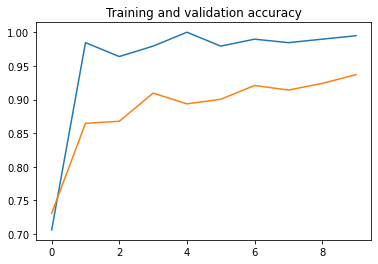

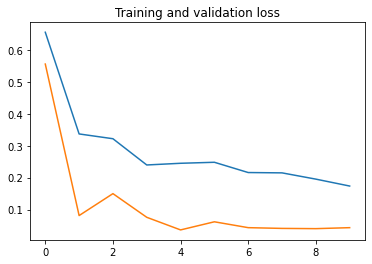

In [ ]:
draw_plt(train_acc,test_acc,train_loss,test_loss)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.6122 Acc:0.7650

test Loss: 0.4062 Acc:0.7990

Epoch 1/19
----------
train Loss: 0.3651 Acc:0.8532

test Loss: 0.5703 Acc:0.7423

Epoch 2/19
----------
train Loss: 0.3131 Acc:0.8707

test Loss: 0.1064 Acc:0.9588

Epoch 3/19
----------
train Loss: 0.2367 Acc:0.9042

test Loss: 0.2017 Acc:0.9485

Epoch 4/19
----------
train Loss: 0.2689 Acc:0.8966

test Loss: 1.3023 Acc:0.7990

Epoch 5/19
----------
train Loss: 0.2238 Acc:0.9034

test Loss: 0.0506 Acc:0.9897

Epoch 6/19
----------
train Loss: 0.1868 Acc:0.9247

test Loss: 0.0567 Acc:0.9794

Epoch 7/19
----------
train Loss: 0.2036 Acc:0.9224

test Loss: 0.0486 Acc:0.9897

Epoch 8/19
----------
train Loss: 0.1925 Acc:0.9179

test Loss: 0.0568 Acc:0.9845

Epoch 9/19
----------
train Loss: 0.2034 Acc:0.9194

test Loss: 0.0516 Acc:0.9845

Epoch 10/19
----------
train Loss: 0.1793 Acc:0.9247

test Loss: 0.0698 Acc:0.9794

Epoch 11/19
----------
train Loss: 0.1904 Acc:0.9278

test Loss: 0.0564 Acc:0.9845

Epoch 12/19
----------
t

pretrained=False   
muixup = True

In [ ]:
model_ft = models.resnet101(pretrained=False)

num_frts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_frts, len(class_names))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft,train_acc,test_acc,train_loss,test_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10,mixup=True)

mixup :  True
Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.7283 Acc:0.6458

test Loss: 1.3184 Acc:0.7629

Epoch 1/9
----------
train Loss: 0.5506 Acc:0.7264

test Loss: 0.4845 Acc:0.7526

Epoch 2/9
----------
train Loss: 0.5217 Acc:0.7547

test Loss: 2.3897 Acc:0.5515

Epoch 3/9
----------
train Loss: 0.5057 Acc:0.7655

test Loss: 0.2449 Acc:0.9124

Epoch 4/9
----------
train Loss: 0.4862 Acc:0.7788

test Loss: 5.9328 Acc:0.5000

Epoch 5/9
----------
train Loss: 0.4591 Acc:0.7950

test Loss: 0.1140 Acc:0.9588

Epoch 6/9
----------
train Loss: 0.4561 Acc:0.7924

test Loss: 0.1434 Acc:0.9536

Epoch 7/9
----------
train Loss: 0.4552 Acc:0.8014

test Loss: 0.1194 Acc:0.9794

Epoch 8/9
----------
train Loss: 0.4525 Acc:0.7858

test Loss: 0.1126 Acc:0.9845

Epoch 9/9
----------
train Loss: 0.4408 Acc:0.8092

test Loss: 0.1126 Acc:0.9845

Training complete in 4.000000m 23s
Best val acc: 0.984536


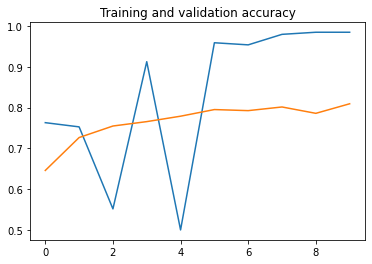

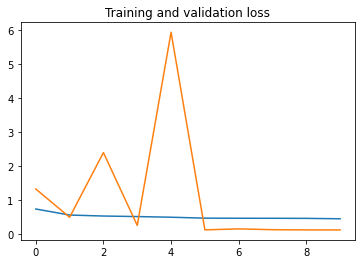

In [ ]:
draw_plt(train_acc,test_acc,train_loss,test_loss)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20,mixup=True)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.7538 Acc:0.6463

test Loss: 3.9553 Acc:0.5825

Epoch 1/19
----------
train Loss: 0.5369 Acc:0.7479

test Loss: 1.7358 Acc:0.7010

Epoch 2/19
----------
train Loss: 0.5090 Acc:0.7672

test Loss: 4.1585 Acc:0.7371

Epoch 3/19
----------
train Loss: 0.4854 Acc:0.7774

test Loss: 1.3748 Acc:0.7938

Epoch 4/19
----------
train Loss: 0.4888 Acc:0.7726

test Loss: 1.9183 Acc:0.7165

Epoch 5/19
----------
train Loss: 0.4650 Acc:0.7919

test Loss: 0.3492 Acc:0.8299

Epoch 6/19
----------
train Loss: 0.4831 Acc:0.7801

test Loss: 0.1321 Acc:0.9794

Epoch 7/19
----------
train Loss: 0.4733 Acc:0.7935

test Loss: 0.1181 Acc:0.9948

Epoch 8/19
----------
train Loss: 0.4449 Acc:0.8000

test Loss: 0.1216 Acc:0.9897

Epoch 9/19
----------
train Loss: 0.4752 Acc:0.7845

test Loss: 0.1409 Acc:0.9639

Epoch 10/19
----------
train Loss: 0.4650 Acc:0.7910

test Loss: 0.1404 Acc:0.9845

Epoch 11/19
----------
train Loss: 0.4497 Acc:0.8004

test Loss: 0.1999 Acc:0.9485

Epoch 12/19
----------
t

pretrained=True  
muixup = True

In [ ]:
model_ft = models.resnet101(pretrained=True)

num_frts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_frts, len(class_names))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft,train_acc,test_acc,train_loss,test_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10,mixup=True)

mixup :  True
Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.4531 Acc:0.8123

test Loss: 0.0575 Acc:0.9845

Epoch 1/9
----------
train Loss: 0.3607 Acc:0.8612

test Loss: 0.0769 Acc:0.9948

Epoch 2/9
----------
train Loss: 0.3620 Acc:0.8580

test Loss: 0.0322 Acc:1.0000

Epoch 3/9
----------
train Loss: 0.3758 Acc:0.8406

test Loss: 0.0664 Acc:1.0000

Epoch 4/9
----------
train Loss: 0.3491 Acc:0.8543

test Loss: 0.1327 Acc:0.9948

Epoch 5/9
----------
train Loss: 0.3636 Acc:0.8523

test Loss: 0.0299 Acc:1.0000

Epoch 6/9
----------
train Loss: 0.3549 Acc:0.8598

test Loss: 0.0343 Acc:1.0000

Epoch 7/9
----------
train Loss: 0.3440 Acc:0.8556

test Loss: 0.0333 Acc:1.0000

Epoch 8/9
----------
train Loss: 0.3513 Acc:0.8475

test Loss: 0.0300 Acc:1.0000

Epoch 9/9
----------
train Loss: 0.3556 Acc:0.8521

test Loss: 0.0354 Acc:1.0000

Training complete in 9.000000m 50s
Best val acc: 1.000000


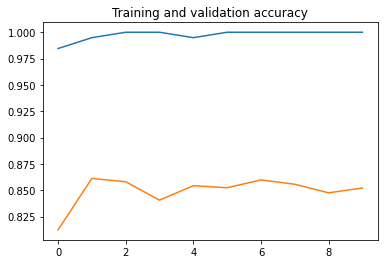

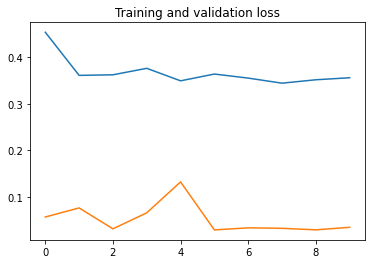

In [ ]:
draw_plt(train_acc,test_acc,train_loss,test_loss)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20,mixup=True)

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.4704 Acc:0.7995

test Loss: 0.0518 Acc:0.9948

Epoch 1/19
----------
train Loss: 0.4009 Acc:0.8367

test Loss: 0.1647 Acc:1.0000

Epoch 2/19
----------
train Loss: 0.3933 Acc:0.8376

test Loss: 0.0985 Acc:1.0000

Epoch 3/19
----------
train Loss: 0.3618 Acc:0.8443

test Loss: 0.0397 Acc:1.0000

Epoch 4/19
----------
train Loss: 0.3862 Acc:0.8361

test Loss: 0.0480 Acc:1.0000

Epoch 5/19
----------
train Loss: 0.3634 Acc:0.8523

test Loss: 0.0573 Acc:1.0000

Epoch 6/19
----------
train Loss: 0.3510 Acc:0.8543

test Loss: 0.0395 Acc:1.0000

Epoch 7/19
----------
train Loss: 0.3456 Acc:0.8511

test Loss: 0.0485 Acc:1.0000

Epoch 8/19
----------
train Loss: 0.3499 Acc:0.8491

test Loss: 0.0381 Acc:1.0000

Epoch 9/19
----------
train Loss: 0.3333 Acc:0.8610

test Loss: 0.0422 Acc:1.0000

Epoch 10/19
----------
train Loss: 0.3492 Acc:0.8468

test Loss: 0.0471 Acc:1.0000

Epoch 11/19
----------
train Loss: 0.3265 Acc:0.8636

test Loss: 0.0448 Acc:1.0000

Epoch 12/19
----------
t

pretrained=True  
muixup = False

In [ ]:
model_ft = models.resnet101(pretrained=True)

num_frts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_frts, len(class_names))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft,train_acc,test_acc,train_loss,test_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10,mixup=False)

mixup :  False
Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.1968 Acc:0.9194

test Loss: 0.0672 Acc:0.9845

Epoch 1/9
----------
train Loss: 0.0967 Acc:0.9605

test Loss: 0.0156 Acc:0.9897

Epoch 2/9
----------
train Loss: 0.0854 Acc:0.9574

test Loss: 0.0023 Acc:1.0000

Epoch 3/9
----------
train Loss: 0.0656 Acc:0.9696

test Loss: 0.0003 Acc:1.0000

Epoch 4/9
----------
train Loss: 0.0757 Acc:0.9597

test Loss: 0.0812 Acc:0.9948

Epoch 5/9
----------
train Loss: 0.0905 Acc:0.9627

test Loss: 0.0028 Acc:1.0000

Epoch 6/9
----------
train Loss: 0.0852 Acc:0.9627

test Loss: 0.0091 Acc:0.9948

Epoch 7/9
----------
train Loss: 0.0830 Acc:0.9483

test Loss: 0.0048 Acc:0.9948

Epoch 8/9
----------
train Loss: 0.0795 Acc:0.9665

test Loss: 0.0014 Acc:1.0000

Epoch 9/9
----------
train Loss: 0.0847 Acc:0.9650

test Loss: 0.0040 Acc:1.0000

Training complete in 4.000000m 20s
Best val acc: 1.000000


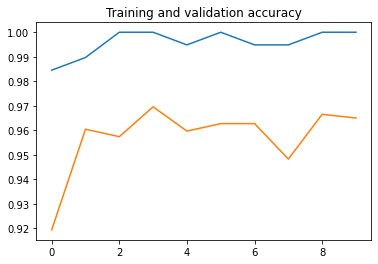

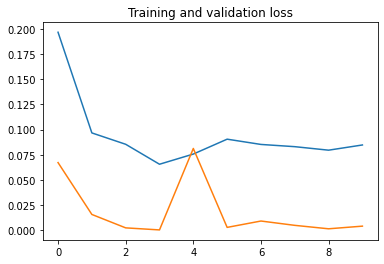

In [ ]:
draw_plt(train_acc,test_acc,train_loss,test_loss)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20,mixup=False)

Epoch 0/19
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.2466 Acc:0.8996

test Loss: 0.6087 Acc:0.7423

Epoch 1/19
----------
train Loss: 0.1208 Acc:0.9529

test Loss: 0.0026 Acc:1.0000

Epoch 2/19
----------
train Loss: 0.1077 Acc:0.9452

test Loss: 0.1418 Acc:0.9794

Epoch 3/19
----------
train Loss: 0.1089 Acc:0.9513

test Loss: 0.0028 Acc:1.0000

Epoch 4/19
----------
train Loss: 0.0730 Acc:0.9620

test Loss: 0.0012 Acc:1.0000

Epoch 5/19
----------
train Loss: 0.0631 Acc:0.9711

test Loss: 0.0007 Acc:1.0000

Epoch 6/19
----------
train Loss: 0.0617 Acc:0.9643

test Loss: 0.0004 Acc:1.0000

Epoch 7/19
----------
train Loss: 0.0625 Acc:0.9711

test Loss: 0.0004 Acc:1.0000

Epoch 8/19
----------
train Loss: 0.0676 Acc:0.9582

test Loss: 0.0005 Acc:1.0000

Epoch 9/19
----------
train Loss: 0.0636 Acc:0.9764

test Loss: 0.0003 Acc:1.0000

Epoch 10/19
----------
train Loss: 0.0608 Acc:0.9673

test Loss: 0.0004 Acc:1.0000

Epoch 11/19
----------
train Loss: 0.0503 Acc:0.9764

test Loss: 0.0008 Acc:1.0000

Epoch 12/19
----------
t

위 과정을 비교하면 mixup을 사용한것이 정확도가 높았다.  
pretrain으로 미리 특징을 잘 모았다면 mixup으로 학습하는 것이 더 빠르게 학습할 수 있었다.

### 2. 벌과 개미
이번에는 2개의 class를 적은 데이터가 아닌 많은 데이터와 비교하고자 한다.

In [ ]:
import os
import zipfile
from google.colab import drive
drive.mount('/content/drive')
local_zip = '/content/drive/MyDrive/task4/hymenoptera_data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('data/hymenoptera_data')
zip_ref.close()
base_dir = 'data/hymenoptera_data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'val')

Mounted at /content/drive


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


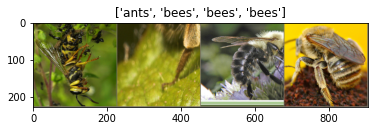

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
mixup_alpha = 1.0

def mixup_data(x, y):
    lam = np.random.beta(mixup_alpha, mixup_alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20,mixup=False):
    train_acc_list=[]
    test_acc_list=[]
    train_loss_list=[]
    test_loss_list=[]
    since = time.time()
    best_acc = 0.0
    best_model = copy.deepcopy(model.state_dict())
    
    new_freeze_state = None
    prev_freeze_state = False
    print("mixup : ",mixup )


    for epoch in range(num_epochs):                               # 에폭 반복
        print("Epoch {}/{}".format(epoch, num_epochs - 1))     
        print('-' * 10)

        for phase in ['train', 'val']:                           # Train이냐 Test이냐
            if phase == 'train':
                scheduler.step()                                  # 학습률을 관리하는 스케쥴
                model.train()                                     # 학습
            else:
                model.eval()                                      # 평가
                
            running_loss = 0.0       # 손실
            running_corrects = 0     # 정확도

            train_loss = 0   # mixup
            correct = 0
            total = 0        #
        
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)                # 입력과 라벨을 꺼낸다
                if phase == 'train' and mixup==True:
                    inputs, targets_a, targets_b, lam = mixup_data(inputs, labels) # mixup

                optimizer.zero_grad()                     # 기울기값을 초기화해주지 않으면 남아있는 경우가 있어 필수이다.
                
                
                with torch.set_grad_enabled(phase == 'train'):  # 기울기를 설정할 수 있는 층이면
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)            

                    if phase == 'train' and mixup==True:
                        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam) #mixup
                    else :
                        loss = criterion(outputs, labels)     #cross_entropy

                    if phase == 'train':                      #train 일때만 역전파
                      loss.backward()
                      optimizer.step()                        # params 수정
                    
                    running_loss += loss.item() * inputs.size(0)
                    if phase == 'train' and mixup==True:
                      running_corrects +=(lam * preds.eq(targets_a).sum().item() + (1 - lam) * preds.eq(targets_b).sum().item())  #mixup
                    else:
                      running_corrects += preds.eq(labels).sum().item()     # 미니배치중 맞힌 겟수

            epoch_loss = running_loss / dataset_sizes[phase]      # 맞힌 확률
            epoch_acc = running_corrects / dataset_sizes[phase]
            if phase == 'train':
              train_acc_list.append(epoch_acc)
              train_loss_list.append(epoch_loss)
            else:
              test_acc_list.append(epoch_acc)
              test_loss_list.append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc:{:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
            
            print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model)
    return model,train_acc_list,test_acc_list,train_loss_list,test_loss_list
                

mixup :  True
Epoch 0/49
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.6682 Acc:0.6536

val Loss: 0.4392 Acc:0.8235

Epoch 1/49
----------
train Loss: 0.5283 Acc:0.7349

val Loss: 0.5446 Acc:0.8039

Epoch 2/49
----------
train Loss: 0.4761 Acc:0.7974

val Loss: 0.3628 Acc:0.8693

Epoch 3/49
----------
train Loss: 0.5177 Acc:0.7745

val Loss: 0.4089 Acc:0.8562

Epoch 4/49
----------
train Loss: 0.5266 Acc:0.7494

val Loss: 0.3212 Acc:0.9020

Epoch 5/49
----------
train Loss: 0.4442 Acc:0.7853

val Loss: 0.3194 Acc:0.8758

Epoch 6/49
----------
train Loss: 0.4665 Acc:0.8085

val Loss: 0.3184 Acc:0.8824

Epoch 7/49
----------
train Loss: 0.4963 Acc:0.7791

val Loss: 0.3390 Acc:0.8824

Epoch 8/49
----------
train Loss: 0.4575 Acc:0.8057

val Loss: 0.4673 Acc:0.8301

Epoch 9/49
----------
train Loss: 0.4589 Acc:0.7945

val Loss: 0.4239 Acc:0.8497

Epoch 10/49
----------
train Loss: 0.4696 Acc:0.8122

val Loss: 0.3671 Acc:0.8758

Epoch 11/49
----------
train Loss: 0.4763 Acc:0.8117

val Loss: 0.4218 Acc:0.8497

Epoch 12/49
----------
train Loss: 0

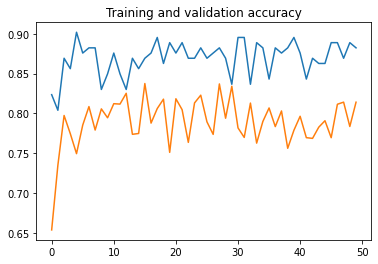

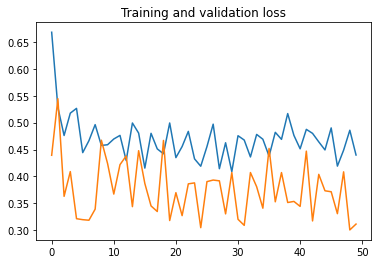

In [ ]:
model_ft = models.resnet101(pretrained=True)

num_frts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_frts, len(class_names))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.0005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft,train_acc_mixup,test_acc_mixup,train_loss_mixup,test_loss_mixup  = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50,mixup=True)

draw_plt(train_acc_mixup,test_acc_mixup,train_loss_mixup,test_loss_mixup)

mixup=True

mixup :  True
Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.6167 Acc:0.6948

val Loss: 0.2946 Acc:0.8758

Epoch 1/9
----------
train Loss: 0.5083 Acc:0.7557

val Loss: 0.4040 Acc:0.8301

Epoch 2/9
----------
train Loss: 0.5583 Acc:0.7328

val Loss: 0.3231 Acc:0.9085

Epoch 3/9
----------
train Loss: 0.5031 Acc:0.7666

val Loss: 0.2952 Acc:0.8562

Epoch 4/9
----------
train Loss: 0.4835 Acc:0.7788

val Loss: 0.2715 Acc:0.8954

Epoch 5/9
----------
train Loss: 0.5111 Acc:0.7862

val Loss: 0.2757 Acc:0.9020

Epoch 6/9
----------
train Loss: 0.4974 Acc:0.7803

val Loss: 0.2899 Acc:0.8954

Epoch 7/9
----------
train Loss: 0.4709 Acc:0.7906

val Loss: 0.2901 Acc:0.8889

Epoch 8/9
----------
train Loss: 0.4587 Acc:0.8066

val Loss: 0.2337 Acc:0.9412

Epoch 9/9
----------
train Loss: 0.4407 Acc:0.8044

val Loss: 0.2296 Acc:0.9346

Training complete in 3.000000m 11s
Best val acc: 0.941176


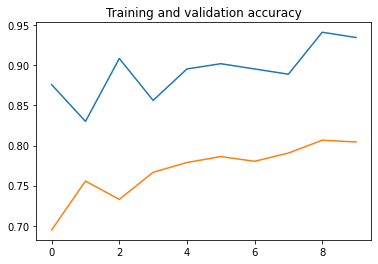

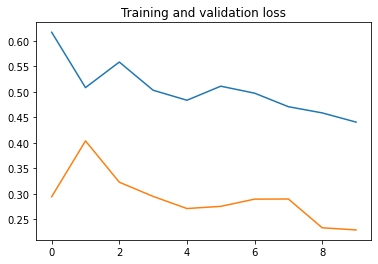

In [ ]:
model_ft = models.resnet101(pretrained=True)

num_frts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_frts, len(class_names))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.0005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft,train_acc_mixup,test_acc_mixup,train_loss_mixup,test_loss_mixup  = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10,mixup=True)

draw_plt(train_acc_mixup,test_acc_mixup,train_loss_mixup,test_loss_mixup)

mixup :  True
Epoch 0/49
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.6539 Acc:0.6577

val Loss: 0.3592 Acc:0.8562

Epoch 1/49
----------
train Loss: 0.5305 Acc:0.7143

val Loss: 0.3006 Acc:0.9020

Epoch 2/49
----------
train Loss: 0.4787 Acc:0.7848

val Loss: 0.3296 Acc:0.8758

Epoch 3/49
----------
train Loss: 0.4524 Acc:0.8022

val Loss: 0.2543 Acc:0.9150

Epoch 4/49
----------
train Loss: 0.4662 Acc:0.7803

val Loss: 0.3314 Acc:0.8758

Epoch 5/49
----------
train Loss: 0.4425 Acc:0.8135

val Loss: 0.2471 Acc:0.9281

Epoch 6/49
----------
train Loss: 0.4575 Acc:0.7892

val Loss: 0.2347 Acc:0.9281

Epoch 7/49
----------
train Loss: 0.4602 Acc:0.8127

val Loss: 0.2878 Acc:0.9085

Epoch 8/49
----------
train Loss: 0.4704 Acc:0.7703

val Loss: 0.2861 Acc:0.9085

Epoch 9/49
----------
train Loss: 0.3733 Acc:0.8442

val Loss: 0.2462 Acc:0.9216

Epoch 10/49
----------
train Loss: 0.4339 Acc:0.8014

val Loss: 0.2818 Acc:0.9085

Epoch 11/49
----------
train Loss: 0.4673 Acc:0.8001

val Loss: 0.2827 Acc:0.9020

Epoch 12/49
----------
train Loss: 0

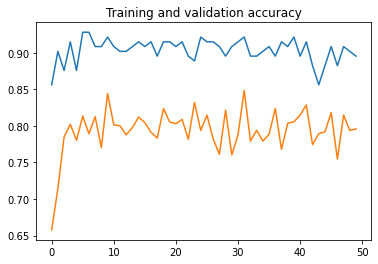

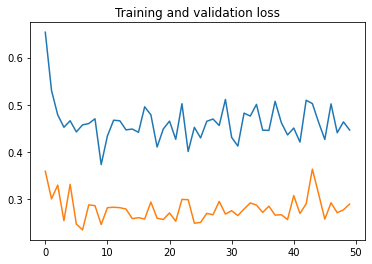

In [ ]:
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.0005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft,train_acc_mixup,test_acc_mixup,train_loss_mixup,test_loss_mixup  = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50,mixup=True)

draw_plt(train_acc_mixup,test_acc_mixup,train_loss_mixup,test_loss_mixup)

mixup=False

mixup :  False
Epoch 0/49
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.5816 Acc:0.7336

val Loss: 0.3097 Acc:0.8889

Epoch 1/49
----------
train Loss: 0.4657 Acc:0.8033

val Loss: 0.2473 Acc:0.9085

Epoch 2/49
----------
train Loss: 0.3460 Acc:0.8484

val Loss: 0.2790 Acc:0.9085

Epoch 3/49
----------
train Loss: 0.3178 Acc:0.8770

val Loss: 0.2963 Acc:0.8954

Epoch 4/49
----------
train Loss: 0.2783 Acc:0.8811

val Loss: 0.2488 Acc:0.9085

Epoch 5/49
----------
train Loss: 0.2400 Acc:0.9098

val Loss: 0.2028 Acc:0.9346

Epoch 6/49
----------
train Loss: 0.2895 Acc:0.8975

val Loss: 0.2099 Acc:0.9281

Epoch 7/49
----------
train Loss: 0.2390 Acc:0.9098

val Loss: 0.1928 Acc:0.9346

Epoch 8/49
----------
train Loss: 0.2507 Acc:0.9016

val Loss: 0.2008 Acc:0.9216

Epoch 9/49
----------
train Loss: 0.2834 Acc:0.8893

val Loss: 0.1885 Acc:0.9346

Epoch 10/49
----------
train Loss: 0.3092 Acc:0.8934

val Loss: 0.2197 Acc:0.9216

Epoch 11/49
----------
train Loss: 0.2304 Acc:0.9057

val Loss: 0.2316 Acc:0.9085

Epoch 12/49
----------
train Loss: 0

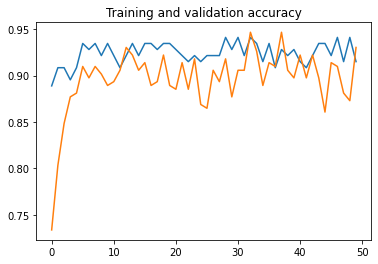

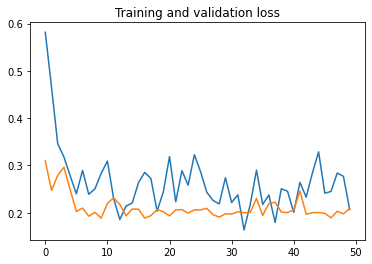

In [ ]:
model_ft = models.resnet101(pretrained=True)

num_frts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_frts, len(class_names))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.0005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft,train_acc,test_acc,train_loss,test_loss  = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50,mixup=False)

draw_plt(train_acc,test_acc,train_loss,test_loss)

mixup :  False
Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.5600 Acc:0.7172

val Loss: 0.2677 Acc:0.9085

Epoch 1/9
----------
train Loss: 0.3162 Acc:0.8689

val Loss: 0.2735 Acc:0.9085

Epoch 2/9
----------
train Loss: 0.3390 Acc:0.8689

val Loss: 0.3370 Acc:0.8627

Epoch 3/9
----------
train Loss: 0.2787 Acc:0.8811

val Loss: 0.2663 Acc:0.8889

Epoch 4/9
----------
train Loss: 0.3198 Acc:0.8811

val Loss: 0.2140 Acc:0.9216

Epoch 5/9
----------
train Loss: 0.3056 Acc:0.8811

val Loss: 0.2690 Acc:0.9216

Epoch 6/9
----------
train Loss: 0.1859 Acc:0.9426

val Loss: 0.2462 Acc:0.9150

Epoch 7/9
----------
train Loss: 0.1935 Acc:0.9344

val Loss: 0.2270 Acc:0.9281

Epoch 8/9
----------
train Loss: 0.2515 Acc:0.8893

val Loss: 0.2509 Acc:0.9216

Epoch 9/9
----------
train Loss: 0.2399 Acc:0.8852

val Loss: 0.2628 Acc:0.9150

Training complete in 3.000000m 12s
Best val acc: 0.928105


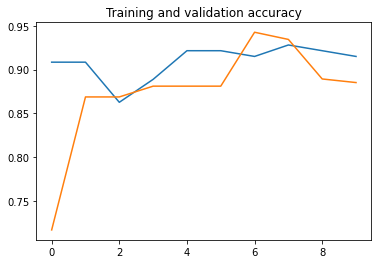

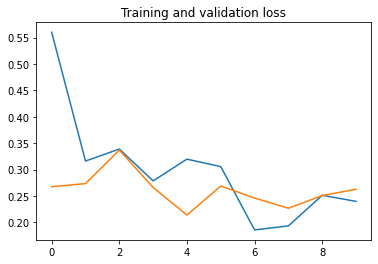

In [ ]:
model_ft = models.resnet101(pretrained=True)

num_frts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_frts, len(class_names))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.0005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft,train_acc,test_acc,train_loss,test_loss  = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10,mixup=False)

draw_plt(train_acc,test_acc,train_loss,test_loss)

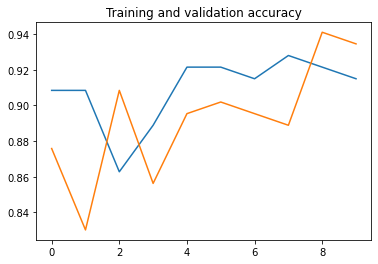

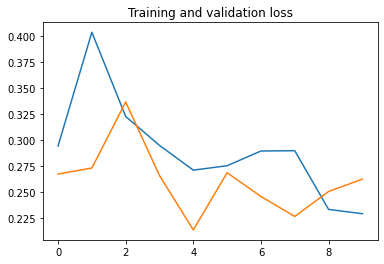

In [ ]:
draw_plt(test_acc_mixup,test_acc,test_loss_mixup,test_loss)

# 3. 비행기 분류
이번에는 지난번 과제였던 비행기 분류를 가지고 mixup을 적용해볼것이다.  

모델은 마찬가지로 resnet 101을 사용할것이다.  

아시다시피 비행기 데이터셋은 불균일하게 이루어져 있다.

지난번 하지 못했던 균일화 작업도 추가적으로 구성했다.

In [ ]:
import os
import zipfile
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

local_zip = '/content/drive/MyDrive/task2/assignment2.zip'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('observations/experiements/dest_folder/')
zip_ref.close()
base_dir = 'observations/experiements/dest_folder/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training plane pictures
train_Yakovlev_dir = os.path.join(train_dir, 'Yakovlev')
train_Saab_dir = os.path.join(train_dir, 'Saab')
train_Robin_dir = os.path.join(train_dir, 'Robin')
train_McDonnell_Douglas_dir = os.path.join(train_dir, 'McDonnell_Douglas')
train_Lockheed_Martin_dir = os.path.join(train_dir, 'Lockheed_Martin')
train_Eurofighter_dir = os.path.join(train_dir, 'Eurofighter')
train_Embraer_dir = os.path.join(train_dir, 'Embraer')
train_Canadair_dir = os.path.join(train_dir, 'Canadair')
train_Boeing_dir = os.path.join(train_dir, 'Boeing')
train_Airbus_dir = os.path.join(train_dir, 'Airbus')


# Directory with our test plane pictures
test_Yakovlev_dir = os.path.join(test_dir, 'Yakovlev')
test_Saab_dir = os.path.join(test_dir, 'Saab')
test_Robin_dir = os.path.join(test_dir, 'Robin')
test_McDonnell_Douglas_dir = os.path.join(test_dir, 'McDonnell_Douglas')
test_Lockheed_Martin_dir = os.path.join(test_dir, 'Lockheed_Martin')
test_Eurofighter_dir = os.path.join(test_dir, 'Eurofighter')
test_Embraer_dir = os.path.join(test_dir, 'Embraer')
test_Canadair_dir = os.path.join(test_dir, 'Canadair')
test_Boeing_dir = os.path.join(test_dir, 'Boeing')
test_Airbus_dir = os.path.join(test_dir, 'Airbus')


In [ ]:
print('total training Yakoviev planes images:', len(os.listdir(train_Yakovlev_dir)))
print('total training Saab planes images:', len(os.listdir(train_Saab_dir)))
print('total training Robin planes images:', len(os.listdir(train_Robin_dir)))
print('total training McDonnell_Douglas planes images:', len(os.listdir(train_McDonnell_Douglas_dir)))
print('total training Lockheed_Martin planes images:', len(os.listdir(train_Lockheed_Martin_dir)))
print('total training Eurofighter planes images:', len(os.listdir(train_Eurofighter_dir)))
print('total training Embraer planes images:', len(os.listdir(train_Embraer_dir)))
print('total training Canadair planes images:', len(os.listdir(train_Canadair_dir)))
print('total training Boeing planes images:', len(os.listdir(train_Boeing_dir)))
print('total training Airbus planes images:', len(os.listdir(train_Airbus_dir)))
print()
print('total test Yakoviev planes images:', len(os.listdir(test_Yakovlev_dir)))
print('total test Saab planes images:', len(os.listdir(test_Saab_dir)))
print('total test Robin planes images:', len(os.listdir(test_Robin_dir)))
print('total test McDonnell_Douglas planes images:', len(os.listdir(test_McDonnell_Douglas_dir)))
print('total test Lockheed_Martin planes images:', len(os.listdir(test_Lockheed_Martin_dir)))
print('total test Eurofighter planes images:', len(os.listdir(test_Eurofighter_dir)))
print('total test Embraer planes images:', len(os.listdir(test_Embraer_dir)))
print('total test Canadair planes images:', len(os.listdir(test_Canadair_dir)))
print('total test Boeing planes images:', len(os.listdir(test_Boeing_dir)))
print('total test Airbus planes images:', len(os.listdir(test_Airbus_dir)))

total training Yakoviev planes images: 67
total training Saab planes images: 134
total training Robin planes images: 66
total training McDonnell_Douglas planes images: 467
total training Lockheed_Martin planes images: 67
total training Eurofighter planes images: 66
total training Embraer planes images: 467
total training Canadair planes images: 267
total training Boeing planes images: 1466
total training Airbus planes images: 867

total test Yakoviev planes images: 33
total test Saab planes images: 66
total test Robin planes images: 34
total test McDonnell_Douglas planes images: 233
total test Lockheed_Martin planes images: 33
total test Eurofighter planes images: 34
total test Embraer planes images: 233
total test Canadair planes images: 133
total test Boeing planes images: 734
total test Airbus planes images: 433


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import time
import copy
from collections import Counter
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

In [ ]:
experiments_path = 'observations/experiements/dest_folder/'
# data_path = 'observations/experiements/data/'

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'test' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

불균형하게 되어 있는 데이터 셋을 무게를 이용하여 같은 확률로 뽑히게 해주는 함수이다.


In [ ]:
def load_data(x_path):
  dataset = datasets.ImageFolder(root =os.path.join(experiments_path, x_path), transform=data_transforms[x_path])

  train_classes = [label for _, label in dataset]
  print(len(dataset))
  # Need to get weight for every image in the dataset
  class_count = Counter(train_classes)
  print(class_count)
  class_weights = torch.Tensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
  # Can't iterate over class_count because dictionary is unordered
  print(class_weights)
  sample_weights = [0] * len(dataset)
  for idx, (image, label) in enumerate(dataset):
      class_weight = class_weights[label]
      sample_weights[idx] = class_weight
  print(len(sample_weights))

  print(sample_weights)
  sampler = WeightedRandomSampler(weights=sample_weights,
                                  num_samples = len(dataset), replacement=True)  
  
  train_loader = DataLoader(dataset, sampler=sampler, batch_size=16, num_workers=4)
  print("train_loader",train_loader)
  return train_loader
  

In [ ]:
dataloaders= {x:load_data(x) for x in ['train', 'test']}

5249
Counter({1: 1466, 0: 867, 10: 658, 11: 657, 3: 467, 6: 467, 2: 267, 8: 134, 5: 67, 9: 67, 4: 66, 7: 66})
tensor([ 6.0542,  3.5805, 19.6592, 11.2398, 79.5303, 78.3433, 11.2398, 79.5303,
        39.1716, 78.3433,  7.9772,  7.9893])
5249
[tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(6.0542), tensor(

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


2160
Counter({1: 734, 0: 433, 3: 233, 6: 233, 2: 133, 10: 97, 11: 97, 8: 66, 4: 34, 7: 34, 5: 33, 9: 33})
tensor([ 4.9885,  2.9428, 16.2406,  9.2704, 63.5294, 65.4545,  9.2704, 63.5294,
        32.7273, 65.4545, 22.2680, 22.2680])
2160
[tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.9885), tensor(4.98

In [ ]:
  dataset = datasets.ImageFolder(root =os.path.join(experiments_path, "train"), transform=data_transforms["train"])

  classes = {v: k for k, v in dataset.class_to_idx.items()}
  print("class : ",classes)

class :  {0: 'Airbus', 1: 'Boeing', 2: 'Canadair', 3: 'Embraer', 4: 'Eurofighter', 5: 'Lockheed_Martin', 6: 'McDonnell_Douglas', 7: 'Robin', 8: 'Saab', 9: 'Yakovlev', 10: 'with_mask', 11: 'without_mask'}


In [ ]:
dataloaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7fc70b010b50>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7fc7273d49d0>}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cpu')

In [ ]:
dataset_sizes = {'train':3934, 'test':1966}

# Mixup 함수

In [ ]:
mixup_alpha = 1.0

def mixup_data(x, y):
    lam = np.random.beta(mixup_alpha, mixup_alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

### Training the model

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20,mixup=False):
    train_acc_list=[]
    test_acc_list=[]
    train_loss_list=[]
    test_loss_list=[]
    since = time.time()
    best_acc = 0.0
    best_model = copy.deepcopy(model.state_dict())
    
    new_freeze_state = None
    prev_freeze_state = False
    print("mixup : ",mixup )


    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0

            train_loss = 0   # mixup
            correct = 0
            total = 0        #
        
            one=0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                if phase == 'train' and mixup==True:
                    inputs, targets_a, targets_b, lam = mixup_data(inputs, labels) # mixup
                optimizer.zero_grad()
                
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train' and mixup==True:
                      loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam) #mixup
                    else :
                      loss = criterion(outputs, labels)

                    if phase == 'train':
                      loss.backward()
                      optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    if phase == 'train' and mixup==True:
                      running_corrects +=(lam * preds.eq(targets_a).sum().item() + (1 - lam) * preds.eq(targets_b).sum().item())  #mixup

                    else:
                      running_corrects += preds.eq(labels).sum().item()     

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            if phase == 'train':
              train_acc_list.append(epoch_acc)
              train_loss_list.append(epoch_loss)
            else:
              test_acc_list.append(epoch_acc)
              test_loss_list.append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc:{:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
            
            print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model)
    return model,train_acc_list,test_acc_list,train_loss_list,test_loss_list
                

epoch 이 10일때부터 큰 변화가 없어 10까지만 적었다.  


In [ ]:
model_ft = models.resnet101(pretrained=True)

num_frts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_frts, len(classes))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.0005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft,train_acc,test_acc,train_loss,test_loss  = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50,mixup=False)


mixup :  False
Epoch 0/49
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 1.3381 Acc:0.8531

test Loss: 0.6255 Acc:0.8576

Epoch 1/49
----------
train Loss: 0.8300 Acc:1.0351

test Loss: 0.4554 Acc:0.9339

Epoch 2/49
----------
train Loss: 0.6836 Acc:1.0890

test Loss: 0.4156 Acc:0.9400

Epoch 3/49
----------
train Loss: 0.6105 Acc:1.1162

test Loss: 0.4077 Acc:0.9481

Epoch 4/49
----------
train Loss: 0.5208 Acc:1.1502

test Loss: 0.3846 Acc:0.9624

Epoch 5/49
----------
train Loss: 0.4928 Acc:1.1546

test Loss: 0.3531 Acc:0.9705

Epoch 6/49
----------
train Loss: 0.4656 Acc:1.1647

test Loss: 0.3468 Acc:0.9705

Epoch 7/49
----------
train Loss: 0.4579 Acc:1.1769

test Loss: 0.3140 Acc:0.9858

Epoch 8/49
----------
train Loss: 0.4181 Acc:1.1906

test Loss: 0.3167 Acc:0.9873

Epoch 9/49
----------
train Loss: 0.4165 Acc:1.1835

test Loss: 0.3184 Acc:0.9725

Epoch 10/49
----------
train Loss: 0.4329 Acc:1.1802

test Loss: 0.3427 Acc:0.9695

Epoch 11/49
----------
train Loss: 0.4059 Acc:1.1891

test Loss: 0.3191 Acc:0.9807

Epoch 12/49
----------
t

In [ ]:
draw_plt(train_acc,test_acc,train_loss,test_loss)

In [ ]:
model_ft = models.resnet101(pretrained=True)

num_frts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_frts, len(classes))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.0005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft,train_acc,test_acc,train_loss,test_loss  = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10,mixup=False)

mixup :  False
Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 1.1776 Acc:0.5798

test Loss: 0.6988 Acc:0.7543

Epoch 1/9
----------
train Loss: 0.7758 Acc:0.7267

test Loss: 0.5741 Acc:0.7813

Epoch 2/9
----------
train Loss: 0.6259 Acc:0.7814

test Loss: 0.4593 Acc:0.8276

Epoch 3/9
----------
train Loss: 0.5130 Acc:0.8198

test Loss: 0.4205 Acc:0.8418

Epoch 4/9
----------
train Loss: 0.4586 Acc:0.8477

test Loss: 0.4250 Acc:0.8321

Epoch 5/9
----------
train Loss: 0.4264 Acc:0.8538

test Loss: 0.4241 Acc:0.8576

Epoch 6/9
----------
train Loss: 0.4243 Acc:0.8490

test Loss: 0.3975 Acc:0.8616

Epoch 7/9
----------
train Loss: 0.4026 Acc:0.8604

test Loss: 0.3805 Acc:0.8678

Epoch 8/9
----------
train Loss: 0.4039 Acc:0.8594

test Loss: 0.3780 Acc:0.8693

Epoch 9/9
----------
train Loss: 0.3885 Acc:0.8635

test Loss: 0.3841 Acc:0.8688

Training complete in 13.000000m 43s
Best val acc: 0.869278


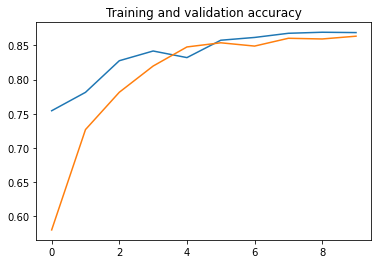

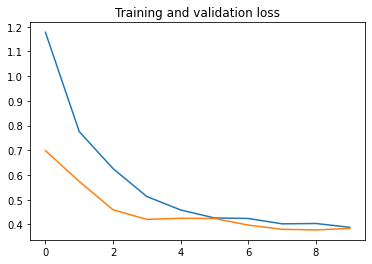

In [ ]:
draw_plt(train_acc,test_acc,train_loss,test_loss)

In [ ]:
model_ft = models.resnet101(pretrained=True)

num_frts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_frts, len(classes))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)


In [ ]:
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.0005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft,train_acc_mixup,test_acc_mixup,train_loss_mixup,test_loss_mixup  = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50,mixup=True)

In [ ]:
draw_plt(train_acc_mixup,test_acc_mixup,train_loss_mixup,test_loss_mixup)

In [ ]:
draw_plt(test_acc_mixup,test_acc,test_loss_mixup,test_loss)

In [ ]:
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.0005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft,train_acc,test_acc,train_loss,test_loss  = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10,mixup=True)

mixup :  True
Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 1.4511 Acc:0.5285

test Loss: 0.5576 Acc:0.8255

Epoch 1/9
----------
train Loss: 1.2925 Acc:0.5996

test Loss: 0.5184 Acc:0.8321

Epoch 2/9
----------
train Loss: 1.2152 Acc:0.6307

test Loss: 0.4485 Acc:0.8505

Epoch 3/9
----------
train Loss: 1.2370 Acc:0.6222

test Loss: 0.4707 Acc:0.8616

Epoch 4/9
----------
train Loss: 1.2134 Acc:0.6270

test Loss: 0.4603 Acc:0.8530

Epoch 5/9
----------
train Loss: 1.2096 Acc:0.6372

test Loss: 0.4525 Acc:0.8499

Epoch 6/9
----------
train Loss: 1.1477 Acc:0.6538

test Loss: 0.4009 Acc:0.8820

Epoch 7/9
----------
train Loss: 1.1468 Acc:0.6617

test Loss: 0.3990 Acc:0.8876

Epoch 8/9
----------
train Loss: 1.1299 Acc:0.6674

test Loss: 0.4147 Acc:0.8713

Epoch 9/9
----------
train Loss: 1.1742 Acc:0.6483

test Loss: 0.4166 Acc:0.8876

Training complete in 13.000000m 51s
Best val acc: 0.887589


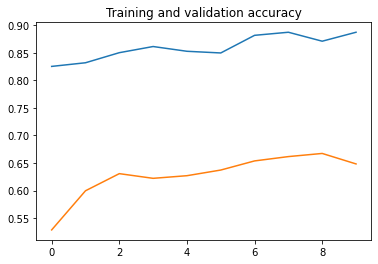

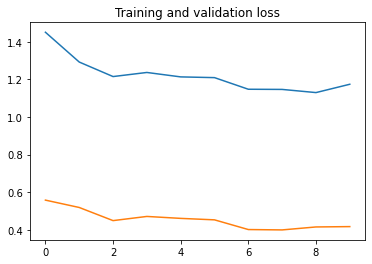

In [ ]:
draw_plt(train_acc,test_acc,train_loss,test_loss)

보는바와 같이 섞은 모델의 loss를 구하기 때문에 Train의 loss는 크지만  
mixup을 안한것은 최대 약 86퍼 mixup을 한것은 약 88퍼로 정확도는 2퍼센트가 올라간 것을 볼 수 있다.